# Weighted spatial means

compare field means using `xarray` and `cdo`

In [1]:
import numpy as np
import cordex as cx
import xarray as xr

from cdo import Cdo
cdo = Cdo()

In [2]:
def spatial_mean(ds):
    """regional mean"""
    return ds.mean(dim=("rlat", "rlon"))

def spatial_mean_weighted(ds):
    """weighted regional mean"""
    weight = np.cos(np.deg2rad(ds.rlat))
    return ds.weighted(weight).mean(dim=("rlat", "rlon"))

In [101]:
ds = cx.tutorial.open_dataset("tas_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_GERICS-REMO2015_v1_mon_197902-198012")

cordex datasets don't have reliable vertices, we replace them with archive specifications

In [102]:
eur11 = cx.cordex_domain('EUR-11', add_vertices=True)
eur11

<xarray.Dataset>
Dimensions:                     (rlon: 424, rlat: 412, vertices: 4)
Coordinates:
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.05 18.16
  * rlat                        (rlat) float64 -23.38 -23.27 ... 21.73 21.84
    lon                         (rlat, rlon) float64 -10.06 -9.964 ... 64.96
    lat                         (rlat, rlon) float64 21.99 22.03 ... 66.75 66.69
Dimensions without coordinates: vertices
Data variables:
    rotated_latitude_longitude  int32 0
    lat_vertices                (rlat, rlon, vertices) float64 22.02 ... 66.7
    lon_vertices                (rlat, rlon, vertices) float64 -10.14 ... 65.15
Attributes:
    CORDEX_domain:  EUR-11

In [103]:
ds['lon_vertices'][:] = eur11.lon_vertices.roll(vertices=0).values
ds['lat_vertices'][:] = eur11.lat_vertices.roll(vertices=0).values

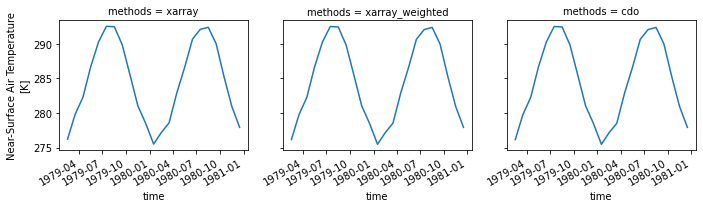

In [104]:
fldmean = spatial_mean(ds.tas)
fldmean_weighted = spatial_mean_weighted(ds.tas)
fldmean_cdo = cdo.fldmean(input=ds, returnXArray='tas').squeeze(drop=True)
res = xr.concat([fldmean, fldmean_weighted, fldmean_cdo], dim=xr.DataArray(['xarray', 'xarray_weighted', 'cdo'], dims='methods')).to_dataset()
res.tas.plot(col='methods')

In [105]:
abs(res.tas.sel(methods=['xarray_weighted', 'cdo']).diff(dim='methods'))#.max()

<xarray.DataArray 'tas' (methods: 1, time: 23)>
array([[4.74183202e-06, 1.35415295e-05, 9.70862510e-06, 5.39797674e-06,
        9.05609284e-06, 4.54656913e-06, 5.09772622e-06, 1.17705290e-05,
        1.21555027e-05, 3.61592237e-06, 9.54954857e-06, 8.43985481e-06,
        1.07265250e-05, 1.42764260e-05, 7.73644331e-07, 1.04147757e-05,
        9.41821554e-08, 2.70024378e-06, 1.37626116e-05, 1.21103449e-05,
        3.24059869e-06, 8.05398071e-06, 1.18383199e-05]])
Coordinates:
  * time     (time) datetime64[ns] 1979-02-15 ... 1980-12-16T12:00:00
    height   float64 2.0
  * methods  (methods) <U15 'cdo'
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    comment:           daily-mean near-surface (usually, 2 meter) air tempera...
    units:             K
    cell_methods:      time: mean
    history:           2018-06-15T15:20:54Z altered by CMOR: Treated scalar d...
    associated_files:  gridspecFile: gridspec_atmos_fx_GERICS-REMO2015_evalua...
    grid_mapping:      rotated_latitude_longitude

So, we get the same results with `np.cos(np.deg2rad(ds.rlat))` weights!

In [106]:
np.testing.assert_allclose(res.tas.sel(methods='xarray_weighted'), res.tas.sel(methods='cdo'))